In [1]:
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE
from pixyz.distributions import Normal
import torch
from torch import nn, optim
from data_loader import PushDataLoader
from core import Inference, Generator
from config import get_args
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

args = get_args(jupyter=True)
device = args.device_ids[0]
z_dim = args.z_dim
epochs = args.epochs

def train(epoch):
    time.sleep(0.5)
    for i, x in enumerate(tqdm(train_loader)):
        x = x.to(device)
        for t in range(args.T):
            loss = model.train({"x": x[:,t]})
        if i % 100 == 0:
            print("loss: {:.4f}".format(loss))
            path = "epoch{:04d}-iter{:05d}-{}.png".format(epoch, i, loss)
            show("./img/vae_"+path)
            
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, loss))
    return train_loss

# def test(epoch):
#     test_loss = 0
#     for x in test_loader:
#         x = x.to(device)
#         for t in range(args.T):
#             loss = model.test({"x": x})
#             test_loss += loss

#     test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
#     print('Test loss: {:.4f}'.format(test_loss))
#     return test_loss

def plot_reconstrunction(x):
    with torch.no_grad():
        z = q.sample({"x": x}, return_all=False)
        recon_batch = p.sample_mean(z).view(-1, 3, 64, 64)
        comparison = torch.cat([x.view(-1, 3, 64, 64), recon_batch]).cpu()
        return comparison

def plot_image_from_latent(z_sample):
    with torch.no_grad():
        sample = p.sample_mean({"z": z_sample}).view(-1, 3, 64, 64).cpu()
        return sample

def show(path):
    recon = plot_reconstrunction(_x[:8])
    sample = plot_image_from_latent(z_sample)
    img = torch.cat([recon, sample[:8]])
    
    plt.figure(figsize=(16,6))
    for i in range(24):
        plt.subplot(3,8,i+1)
        plt.imshow(img[i].numpy().astype(
            np.float).transpose(1,2,0).reshape(64,64,3))
    plt.savefig(path)
    plt.show()

In [2]:
p = Generator(z_dim).to(device)             
q = Inference(z_dim).to(device)

prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)
kl = KullbackLeibler(q, prior)
model = VAE(q, p, regularizer=kl, 
            optimizer=optim.Adam, optimizer_params={"lr":1e-3})

train_loader = PushDataLoader(
    args.path, 'train', args.B, args.epochs)
test_loader = PushDataLoader(
    args.path, 'test', args.B, args.epochs)

z_sample = 0.5 * torch.randn(64, z_dim).to(device)
_x = next(test_loader)[:,0]
_x = _x.to(device)

  0%|          | 0/338 [00:00<?, ?it/s]

loss: 7698.0869


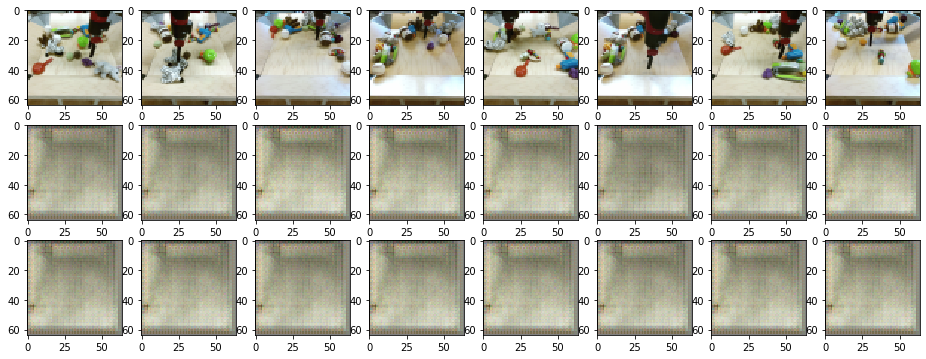

  3%|▎         | 11/338 [00:35<14:14,  2.61s/it] 

KeyboardInterrupt: 

In [3]:
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
#     test_loss = test(epoch)